# Studfarm model (Genealogy)

F.v.Jensen, T.D. Nieslen's book example
Simple genealogy and reasoning on a recessive genetic disease carriers.


In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import pgmpy
import numpy as np
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
import daft
import sys

plt.rcParams['figure.facecolor'] = 'white'

## Transforms pgmpy.models.BayesianModel to daft.PGM
def to_daft(model,pos):
    daft_model=daft.PGM()
    for node in model.nodes:
        daft_model.add_node(daft.Node(node, node,pos[node][0],pos[node][1]))
    for edge in model.edges:
        try:
            daft_model.add_edge(edge[0],edge[1],directed=False)
        except:
            print(sys.exc_info())
    return daft_model


## CPD definitions

In [3]:
prior_carrier=0.001
def top(name):
    return TabularCPD(variable=name, variable_card=2, values=[[prior_carrier], [1-prior_carrier]], 
                      state_names={name: ['carrier', 'clean']})
def middle(name,left, right):
    cpd = TabularCPD(variable=name, variable_card=2, 
                   values=[[2/3, 0.5, 0.5,  0],
                           [1/3, 0.5,  0.5, 1]],
                  evidence=[left, right],
                  evidence_card=[2, 2],
                state_names={name: ['carrier', 'clean'],left: ['carrier', 'clean'],
                             right: ['carrier', 'clean']})
    return cpd
def sink(name,left, right):
    cpd = TabularCPD(variable=name, variable_card=3, 
                   values=[[0.25, 0, 0,  0],
                           [0.5, 0.5, 0.5, 0],
                           [0.25, 0.5,  0.5, 1]],
                  evidence=[left, right],
                  evidence_card=[2, 2],
                state_names={name: ['sick','carrier', 'clean'],left: ['carrier', 'clean'],
                             right: ['carrier', 'clean']})
    return cpd


In [4]:
top('Ann')

<TabularCPD representing P(Ann:2) at 0x26ba8d723a0>

In [5]:
print(sink('John','Henry','Irene'))

+---------------+----------------+----------------+----------------+--------------+
| Henry         | Henry(carrier) | Henry(carrier) | Henry(clean)   | Henry(clean) |
+---------------+----------------+----------------+----------------+--------------+
| Irene         | Irene(carrier) | Irene(clean)   | Irene(carrier) | Irene(clean) |
+---------------+----------------+----------------+----------------+--------------+
| John(sick)    | 0.25           | 0.0            | 0.0            | 0.0          |
+---------------+----------------+----------------+----------------+--------------+
| John(carrier) | 0.5            | 0.5            | 0.5            | 0.0          |
+---------------+----------------+----------------+----------------+--------------+
| John(clean)   | 0.25           | 0.5            | 0.5            | 1.0          |
+---------------+----------------+----------------+----------------+--------------+


In [6]:
print(middle('Gwenn','Ann','K'))

+----------------+--------------------+--------------+------------+------------+
| Ann            | Ann(carrier)       | Ann(carrier) | Ann(clean) | Ann(clean) |
+----------------+--------------------+--------------+------------+------------+
| K              | K(carrier)         | K(clean)     | K(carrier) | K(clean)   |
+----------------+--------------------+--------------+------------+------------+
| Gwenn(carrier) | 0.6666666666666666 | 0.5          | 0.5        | 0.0        |
+----------------+--------------------+--------------+------------+------------+
| Gwenn(clean)   | 0.3333333333333333 | 0.5          | 0.5        | 1.0        |
+----------------+--------------------+--------------+------------+------------+


## Network definition: structure and the cpd list

In [5]:
model = BayesianModel([('L', 'Fred'), ('Ann', 'Fred'), ('Ann', 'Dorothy'), ('Brian', 'Dorothy'),
                       ('Cecily','Eric'),('Brian','Eric'),('Ann','Gwenn'),
                       ('K','Gwenn'), ('Fred', 'Henry'), ('Dorothy','Henry'),('Eric','Irene'),
                       ('Gwenn','Irene'),('Henry','John'),('Irene','John')])

model.add_cpds(top('L'),top('Ann'),top('Brian'),top('Cecily'),top('K'),middle('Fred','L','Ann'),
               middle('Dorothy','Ann','Brian'),
               middle('Eric','Brian','Cecily'),middle('Gwenn','Ann','K'),
               middle('Henry','Fred','Dorothy'),middle('Irene','Eric','Gwenn'),
               sink('John','Henry','Irene'))

## Graphviz vizualization

In [6]:
import graphviz
dot = graphviz.Digraph(comment='Studfarm')

for nd in model.nodes():
    dot.node(nd,nd)

dot.edges(model.edges)
#dot.edge('B', 'L', constraint='false')
#dot.render('test-output/studfarm.gv', view=True) 

## Checking the model consistency

In [7]:
model.check_model()
model.nodes()

NodeView(('L', 'Fred', 'Ann', 'Dorothy', 'Brian', 'Cecily', 'Eric', 'Gwenn', 'K', 'Henry', 'Irene', 'John'))

## Infering the posterior probability

by the variable elimination method

In [8]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
nodes=list(model.nodes)
posterior_p = infer.query(nodes[:11], evidence={'John': 'sick'},joint=False)


for (key, val) in posterior_p.items():
    print('{0:7}[carrier]={1:8.5} %'.format(key, val.values[0]*100))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

L      [carrier]= 0.20783 %
Fred   [carrier]=   43.86 %
Ann    [carrier]=  62.485 %
Dorothy[carrier]=  81.172 %
Brian  [carrier]=  37.558 %
Cecily [carrier]= 0.19125 %
Eric   [carrier]=  37.614 %
Gwenn  [carrier]=    62.5 %
K      [carrier]= 0.18295 %
Henry  [carrier]=   100.0 %
Irene  [carrier]=   100.0 %


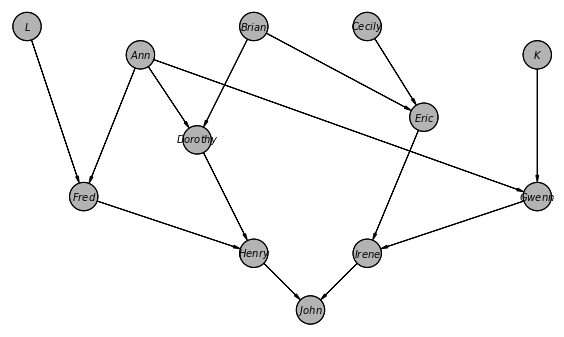

In [10]:
pos={'L':(1,4), 'Fred':(2,3), 'Ann':(3,4), 'Dorothy':(4,3), 'Brian':(5,4), 'Cecily':(7,4),
     'Eric':(6,3), 'Gwenn':(8,3), 'K':(9,4), 'Henry':(3,2), 'Irene':(7,2), 'John':(5,1)}
pos={'L':(1,6), 'Fred':(2,3), 'Ann':(3,5.5), 'Dorothy':(4,4), 'Brian':(5,6), 'Cecily':(7,6),'Eric':(8,4.4), 'Gwenn':(10,3), 'K':(10,5.5), 'Henry':(5,2), 'Irene':(7,2), 'John':(6,1)}

model.to_daft(node_pos=pos).render()

Width: 6
['Ann', 'Dorothy', 'K', 'John', 'L', 'Cecily', 'Gwenn', 'Irene', 'Eric', 'Brian', 'Fred', 'Henry']
Ann: fills [('Fred', 'Dorothy'), ('Fred', 'Gwenn'), ('Dorothy', 'Gwenn')]
Brian: fills [('Dorothy', 'Eric')]


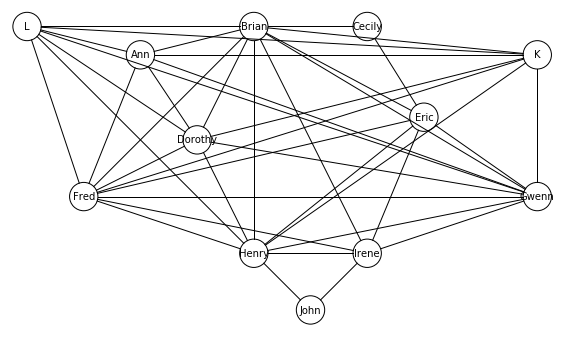

In [11]:
from pgmpy.inference.EliminationOrder import WeightedMinFill

order=list(model.nodes)
order.sort
order=['Ann','Dorothy','K', 'John', 'L', 'Cecily', 'Gwenn', 'Irene', 'Eric', 'Brian',  'Fred',  'Henry']
#order=WeightedMinFill(model).get_elimination_order(nodes=None, show_progress=False)
gg=infer.induced_graph(order)

print('Width: {}'.format(infer.induced_width(order)))
print(order)
mm=to_daft(gg,pos)
mm.render()

elim_o=WeightedMinFill(model)#.get_elimination_order(nodes=None, show_progress=False)
for node in order:
    fill=list(elim_o.fill_in_edges(node))
    if len(fill)>0:
            print('{}: fills {}'.format(node,fill))

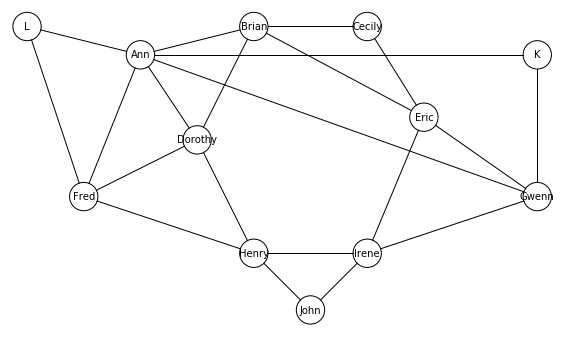

In [13]:
moral=model.to_markov_model()
daft_moral=to_daft(moral, pos)
daft_moral.render()

Finding Elimination Order: : : 0it [00:01, ?it/s]


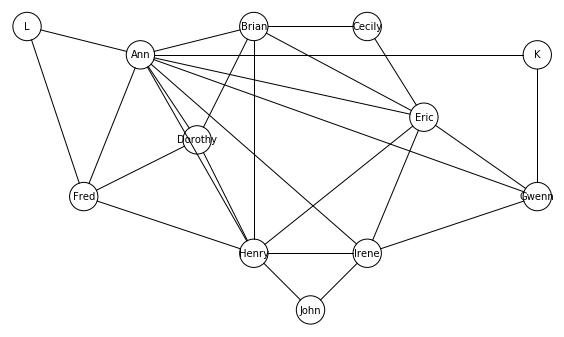

In [14]:
triangulated=moral.triangulate(order=['K', 'John', 'L', 'Cecily', 'Gwenn', 'Irene', 'Eric', 
                                      'Brian', 'Ann', 'Fred', 'Dorothy', 'Henry'])#(heuristic='H6')
daft_triangulated=to_daft(triangulated, pos)
daft_triangulated.render()

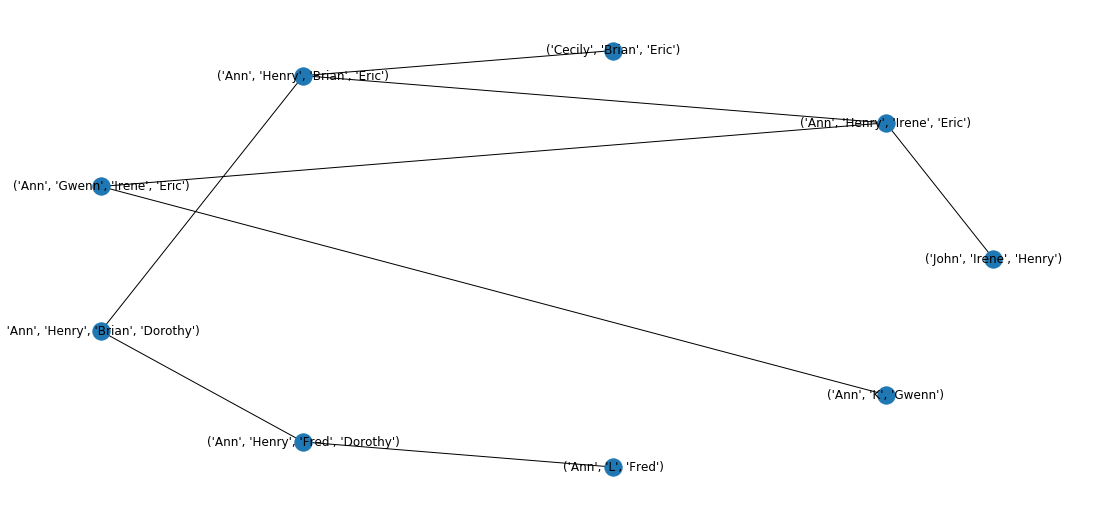

In [22]:
jt=triangulated.to_junction_tree()
plt.rcParams["figure.figsize"] = (15,7)
nx.draw_circular(jt,with_labels=True,)

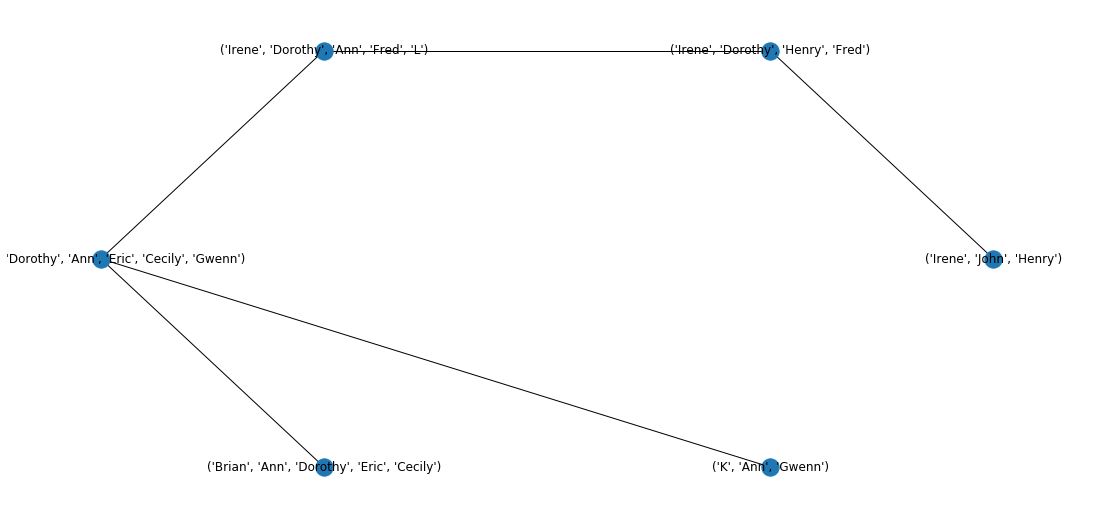

In [23]:
model.check_model()
junction_tree=model.to_junction_tree()
nx.draw_circular(junction_tree,with_labels=True,)

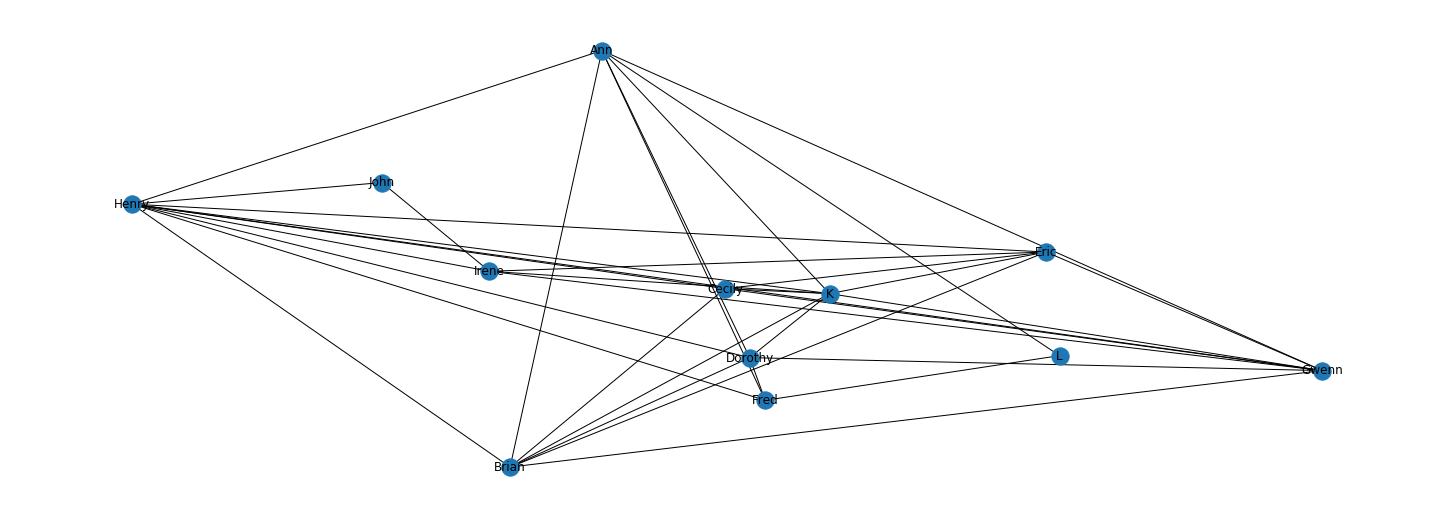

In [17]:
gg=infer.induced_graph(model.nodes)
gg
#.to_daft(node_pos=pos).render()

nx.draw_random(gg,with_labels=True,)

In [18]:
X='Dorothy'
Y='Irene'
my_observations=['Gwenn','Eric']

print(f"Nodes d-connected with {X}? {model.active_trail_nodes(X)}\n")
print(f"Nodes independent from {X} given the parents of {X}? {model.local_independencies(X)}\n")

print(f"Nodes d-connected with  {X} given {my_observations}? {model.active_trail_nodes(X, observed=my_observations)}\n")
print(f"Are d-connected {X} and {Y} given {my_observations}? {model.is_dconnected(X,Y, observed=my_observations)}\n")
try:
    print(f"Minimal d-separator of {X} and {Y}: {model.minimal_dseparator(X, Y)}\n")
except:
    pass


Nodes d-connected with Dorothy? {'Dorothy': {'Brian', 'Henry', 'John', 'Fred', 'Eric', 'Irene', 'Ann', 'Dorothy', 'Gwenn'}}

Nodes independent from Dorothy given the parents of Dorothy? (Dorothy ⟂ L, K, Gwenn, Irene, Fred, Eric, Cecily | Ann, Brian)

Nodes d-connected with  Dorothy given ['Gwenn', 'Eric']? {'Dorothy': {'Brian', 'K', 'Henry', 'John', 'Fred', 'Ann', 'Dorothy', 'Cecily'}}

Are d-connected Dorothy and Irene given ['Gwenn', 'Eric']? False

Minimal d-separator of Dorothy and Irene: {'Eric', 'Gwenn'}



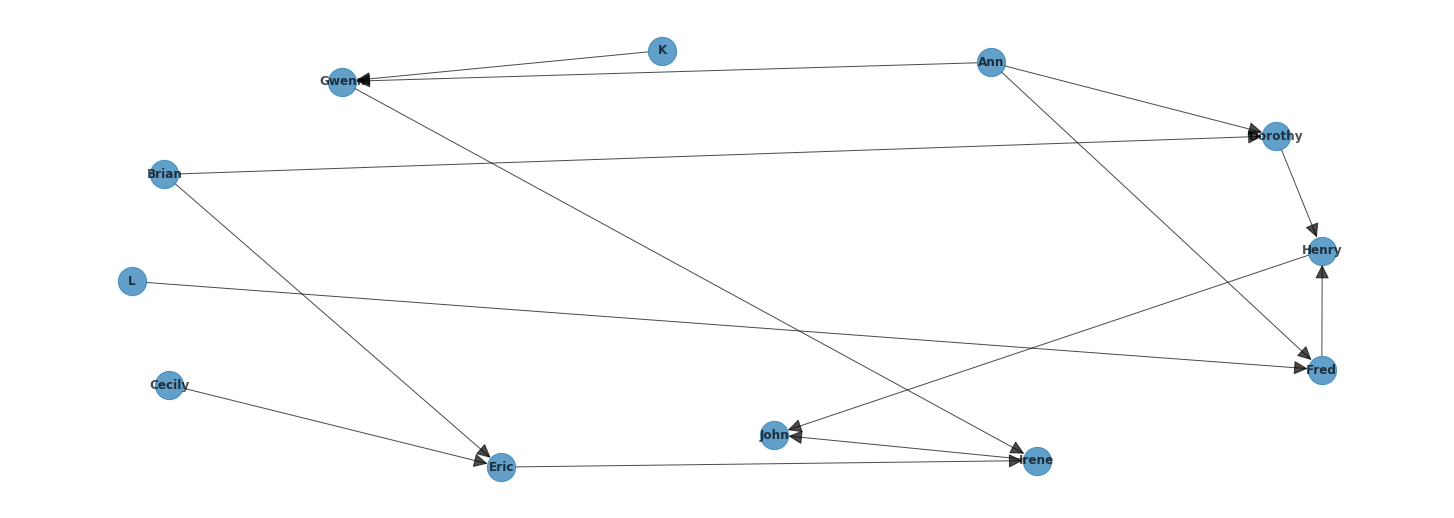

In [19]:
import matplotlib.pyplot as plt
nx.draw(model, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight='bold')
plt.show()

In [20]:
X='Ann'
Y='Irene'
my_observations=['John']

print(f"Nodes d-connected with  {X}? {model.active_trail_nodes(X)}\n")
print(f"Nodes independent from {X} given the parents of {X}? {model.local_independencies(X)}\n")

print(f"Nodes d-connected with  {X} given {my_observations}? {model.active_trail_nodes(X, observed=my_observations)}\n")
print(f"Are d-connected {X} and {Y} given {my_observations}? {model.is_dconnected(X,Y, observed=my_observations)}\n")
try:
    print(f"Minimal d-separator of {X} and {Y}: {model.minimal_dseparator(X, Y)}\n")
except:
    pass


Nodes d-connected with  Ann? {'Ann': {'Henry', 'Ann', 'Irene', 'John', 'Dorothy', 'Fred', 'Gwenn'}}

Nodes independent from Ann given the parents of Ann? (Ann ⟂ L, Brian, K, Eric, Cecily)

Nodes d-connected with  Ann given ['John']? {'Ann': {'K', 'Brian', 'Henry', 'Fred', 'Eric', 'Cecily', 'Gwenn', 'Irene', 'Ann', 'Dorothy', 'L'}}

Are d-connected Ann and Irene given ['John']? True

Minimal d-separator of Ann and Irene: {'Gwenn'}



In [21]:
model.local_independencies(['Gwenn','Eric','Brian'])

(Gwenn ⟂ L, Brian, Henry, Dorothy, Fred, Eric, Cecily | Ann, K)
(Eric ⟂ L, K, Ann, Henry, Dorothy, Fred, Gwenn | Brian, Cecily)
(Brian ⟂ K, Cecily, Gwenn, Ann, Fred, L)